In [272]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
df = pd.read_csv('../data/df.csv')

In [3]:
df

,source,embedding,genres
0,0,"[1.1568369, 4.7216134, -4.829661, 2.67412, 4.1...","[0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,5,"[0.3488815, 6.3227067, -3.6201174, -0.45922923...","[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
2,7,"[-0.07164516, 4.885974, -5.827049, -0.01449445...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,8,"[0.10417974, -3.2304595, 3.5939155, 1.1410666,...","[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
4,11,"[-1.383354, 1.648171, -3.7612596, -1.3233246, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
9120,9140,"[0.28404692, 0.21873271, -0.3254155, 1.6711218...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
9121,9141,"[-0.8980954, -1.6762947, -1.2756481, 0.9909565...","[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
9122,9142,"[0.6182944, -0.6889125, -0.38154954, 1.0363413...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
9123,9143,"[1.9886293, 1.4495139, 1.4017138, 0.2425547, 1...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [362]:
emb_cols = ['d' + str(i) for i in range(1, 101)]
genre_cols = ["Children",
"Animation",
"Romance",
"Musical",
"Thriller",
"Fantasy",
"War",
"Western",
"Crime",
"IMAX",
"Film-Noir",
"Comedy",
"Drama",
"Horror",
"Mystery",
"Documentary",
"Sci-Fi",
"Adventure",
"Action",
"(no genres listed)"]
genre_cols.reverse()
new_df = df.join(pd.DataFrame(df.genres.str.strip("[]").str.split(", ").tolist(), columns=genre_cols, index=df.index, dtype=int))
new_df = new_df.join(pd.DataFrame(new_df.embedding.str.strip("[]").str.split(", ").tolist(), columns=emb_cols, index=new_df.index, dtype=float))
new_df[genre_cols] = new_df[genre_cols].apply(pd.to_numeric, errors='raise')
new_df = new_df.drop(['embedding', 'genres'], axis=1)
data = new_df
del new_df

### 5. PyTorch NN

Transforming pandas dataframe to torch tensor and splitting data into train, validation and test sets

In [234]:
df_features = data[emb_cols]
df_target = data[genre_cols]
X = torch.Tensor(df_features.values).float()
y = torch.Tensor(df_target.values).float()

In [235]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, shuffle=True)

In [236]:
print("Shape of X_train: {}; shape of y_train: {}".format(X_train.shape,y_train.shape))
print("Shape of X_val: {}; shape of y_val: {}".format(X_val.shape,y_val.shape))
print("Shape of X_test: {}; shape of y_test: {}".format(X_test.shape,y_test.shape))

Shape of X_train: torch.Size([6592, 100]); shape of y_train: torch.Size([6592, 20])
Shape of X_val: torch.Size([1164, 100]); shape of y_val: torch.Size([1164, 20])
Shape of X_test: torch.Size([1369, 100]); shape of y_test: torch.Size([1369, 20])


Neural Net (2 layers and ReLu activation):

In [280]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size_1, output_size):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size_1)
        self.layer2 = nn.Linear(hidden_size_1, output_size)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        return x

In [290]:
net = Net(100, 140, 20)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-5)
loss_criterion = nn.MultiLabelSoftMarginLoss()
epochs = 100

Neural net training:

In [291]:
losses = []
losses_val = []
for epoch in range(epochs):
    y_predicted = net(X_train)
    loss = loss_criterion(y_predicted, y_train)
    losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred_val = net(X_val)
        losses_val.append(loss_criterion(y_pred_val, y_val))

Text(0, 0.5, 'MultiLabelSoftMarginLoss')

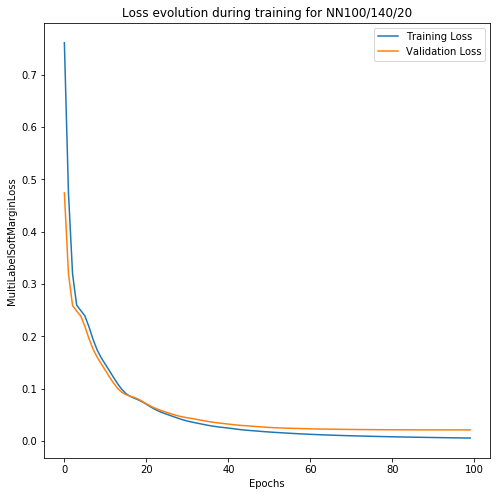

In [370]:
plt.figure(figsize=(8,8))
line_training = plt.plot(losses, label='Training Loss')
line_validation = plt.plot(losses_val, label='Validation Loss')
plt.title("Loss evolution during training for NN100/140/20")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MultiLabelSoftMarginLoss')

#### Model Evaluation:

In [375]:
from sklearn.metrics import multilabel_confusion_matrix, label_ranking_average_precision_score

In [371]:
y_test_pred = net(X_test)

In [273]:
def probs_to_labels(y_elem):
    if y_elem > 0: return 1
    else: return 0
probs_to_labels_vec = np.vectorize(probs_to_labels)

In [374]:
multilabel_confusion_matrix(probs_to_labels_vec(y_test_pred2.detach().numpy()), y_test.numpy())

array([[[1366,    0],
        [   0,    3]],

       [[1134,    9],
        [  11,  215]],

       [[1204,    3],
        [   6,  156]],

       [[1290,    2],
        [   0,   77]],

       [[1281,    3],
        [   2,   83]],

       [[ 851,    9],
        [   9,  500]],

       [[1208,    9],
        [   2,  150]],

       [[1293,    1],
        [   0,   75]],

       [[ 709,   18],
        [  27,  615]],

       [[1254,    4],
        [   4,  107]],

       [[1342,    5],
        [   0,   22]],

       [[1229,    4],
        [   1,  135]],

       [[1349,    3],
        [   0,   17]],

       [[1297,    1],
        [   2,   69]],

       [[1285,    4],
        [   1,   79]],

       [[1123,    9],
        [   6,  231]],

       [[1245,    5],
        [   3,  116]],

       [[1100,   12],
        [  13,  244]],

       [[1308,    7],
        [   1,   53]],

       [[1343,    2],
        [   1,   23]]])

In [380]:
label_ranking_average_precision_score(probs_to_labels_vec(y_test_pred2.detach().numpy()), y_test.numpy()) # greater than 0, best is 1

0.9587624207218794

### Testing with some movies

In [401]:
def get_movie_genres(df, id_movie):
    # Obtain true genres
    genres_true = df[df['source']==id_movie].genres.str.strip("[]").str.split(", ").tolist()
    genres_true = list(map(float,genres_true[0]))
    return genres_true

In [398]:
def predict_movie_genres(df, id_movie, model):
    # Obtain embedding for movie with id_movie
    emb = df[df['source']==id_movie].embedding.str.strip("[]").str.split(", ").tolist()
    emb = list(map(float,emb[0]))
    emb = torch.Tensor(emb).float()
    
    # Predict genres using model
    genres_predicted = model(emb)
    genres_predicted = probs_to_labels_vec(genres_predicted.detach().numpy())
    
    return genres_predicted

In [435]:
def label_to_genre(labels, genres):
    return genre_cols[np.array(np.argwhere(g_p).flatten())]

In [437]:
label_to_genre(probs_to_labels_vec(net(emb9104).detach().numpy()), genre_cols)

TypeError: only integer scalar arrays can be converted to a scalar index

In [417]:
index_genre = np.argwhere(g_p).flatten()

In [421]:
index_genre.flatten()

array([1, 2])

In [432]:
np.array(genre_cols)[np.argwhere(g_p)]

array([['Action'],
       ['Adventure']], dtype='<U18')

In [414]:
genre_cols[np.array(np.argwhere(g_p).flatten())]

TypeError: only integer scalar arrays can be converted to a scalar index

In [402]:
g_p = predict_movie_genres(df, 9123, net)

In [390]:
g_p = g_p.detach().numpy()

In [338]:
emb9123 = df[df['source']==9123].embedding.str.strip("[]").str.split(", ").tolist()
emb9123 = list(map(float,emb9123[0]))
emb9123 = torch.Tensor(emb9123).float()

In [339]:
target9123 = df[df['source']==9123].genres.str.strip("[]").str.split(", ").tolist()

In [320]:
target9123

[['0',
  '1',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0']]

In [340]:
probs_to_labels_vec(net(emb9123).detach().numpy())

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [333]:
emb9104 = df[df['source']==9104].embedding.str.strip("[]").str.split(", ").tolist()
emb9104 = list(map(float,emb9104[0]))
emb9104 = torch.Tensor(emb9104).float()
target9104 = df[df['source']==9104].genres.str.strip("[]").str.split(", ").tolist()

In [334]:
net2(emb9104).detach().numpy()

array([-15.997797, -19.581793, -27.709002, -26.10473 , -23.609785,
       -29.775429, -16.068363, -15.855237,  15.827019, -21.766108,
       -18.844114, -16.519047, -18.866941, -25.212662, -23.801748,
       -21.483915, -26.656443,  13.931328,  -9.225103, -20.784056],
      dtype=float32)

In [345]:
df[df['source']==9104]

,source,embedding,genres
9084,9104,"[2.6167502, -0.22942701, 1.785225, -1.6360013,...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."


In [342]:
target9104[0]

['0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0']

In [335]:
probs_to_labels_vec(net2(emb9104).detach().numpy())

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [346]:
emb0 = df[df['source']==0].embedding.str.strip("[]").str.split(", ").tolist()
emb0 = list(map(float,emb0[0]))
emb0 = torch.Tensor(emb0).float()
target0 = df[df['source']==0].genres.str.strip("[]").str.split(", ").tolist()

In [350]:
target0

[['0',
  '0',
  '1',
  '1',
  '1',
  '1',
  '0',
  '0',
  '0',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0']]

In [349]:
probs_to_labels_vec(net(emb0).detach().numpy())

array([0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [356]:
emb9000 = df[df['source']==9000].embedding.str.strip("[]").str.split(", ").tolist()
emb9000 = list(map(float,emb9000[0]))
emb9000 = torch.Tensor(emb9000).float()
target9000 = df[df['source']==9000].genres.str.strip("[]").str.split(", ").tolist()
probs_to_labels_vec(net(emb9000).detach().numpy())

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [357]:
target9000

[['0',
  '0',
  '0',
  '0',
  '0',
  '1',
  '0',
  '0',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '1',
  '0',
  '0',
  '0',
  '0']]